In [61]:
import numpy
import py_entropy
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot
from matplotlib.lines import Line2D

pyplot.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

In [6]:
basedir = "check-volume-data"

# Set the stage
First set up a simple experiment, consider a chain of $L$ qubits in number sector $M$ with initial state $\rho_x$,
 a mixture of $x$ random computational basis states:
$$\rho_x = \frac{1}{x} \sum_b \ketbra{b}{b}$$
Clearly, $\rho_x$ has purity $\mathcal{P} = \frac{1}{x^2}$.

We define the function `make_mixed_experiments(t,x)` which prepares an initial state $\rho_x$ and runs a depth $t$ number-conserving brickwork circuit, and uses the resulting unitary to compute the purity at each timestep, let $\mathcal{F}[t]$ be the purity estimator:

$$\mathcal{F}[t] = (\mathcal{D}+1)\sum_b \mathbb{P}_t(b)^2 - 1$$

In [4]:
def make_mixed_experiments(n_layers=100, trials=16, num_mixed=16, num_experiments_per_trial=32, L=10, M=5):
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, M)

    unit = numpy.array([1.0 + 0.0j])

    purities = []
    for _ in range(trials):
        choices = numpy.random.choice(numpy.arange(len(states)), replace=False, size=(num_mixed))
        chosen_states = states[choices]
        pure_states = [py_entropy.MultidefectPureState(chosen_states[[i],:], unit) for i in range(num_mixed)]
        state = py_entropy.MultiDefectState.new_mixed_from_states(states=[(1.0/num_mixed, state) for state in pure_states], 
                                                                  n_sites=L,
                                                                  num_experiments=num_experiments_per_trial,
                                                                  skip_float_checks=True)
        purity = state.apply_alternative_layers_and_save_mean_purity(n_layers)
        purities.append(purity)
    return numpy.array(purities)

Let's consider the $M=5$ sector of a chain of length $L=10$, it has hilbert space dimension $\mathcal{D} = {10 \choose 5} = 252$

In [5]:
L = 10
M = 5
states = py_entropy.MultiDefectState.gen_enumerated_states(L, M)
hilbert_d = len(states)
hilbert_d

252

Lets consider initial states for each of $x = \frac{\mathcal{D}}{k}$ for $k = 2^n$, we consider 16 independent $\rho_x$ preparations for each value of $x$ (here called *trials*), and 32 independent unitary realizations for each trial (here called *experiments*).

In [8]:
filename = os.path.join(basedir, "mixtures_1.npz")

if os.path.exists(filename):
    arr = numpy.load(filename)
    true_purities = arr["true_purities"]
    purities = arr["purities"]
else:
    true_purities = []
    purities = []
    
    for num_mixed in [hilbert_d // i for i in 2**numpy.arange(1, 1+int(numpy.floor(numpy.log2(hilbert_d))))][::-1]:
        print(f"Mixing {num_mixed} out of {hilbert_d}")
        purities.append(make_mixed_experiments(n_layers=1000, num_mixed=num_mixed, L=L, M=M, trials=16, num_experiments_per_trial=32))
        true_purities.append(1/num_mixed)
    purities = numpy.array(purities)
    true_purities = numpy.array(true_purities)
    numpy.savez(filename, purities=purities, true_purities=true_purities)

Mixing 1 out of 252
Mixing 3 out of 252
Mixing 7 out of 252
Mixing 15 out of 252
Mixing 31 out of 252
Mixing 63 out of 252
Mixing 126 out of 252


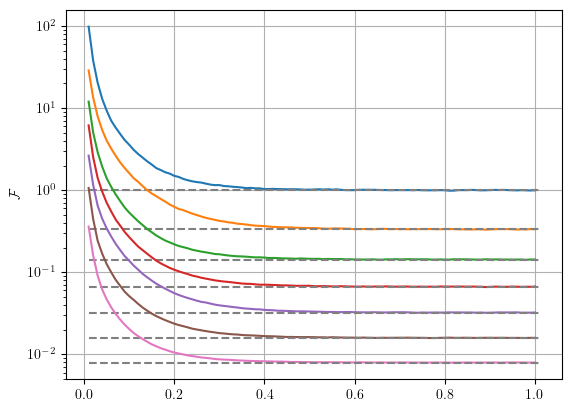

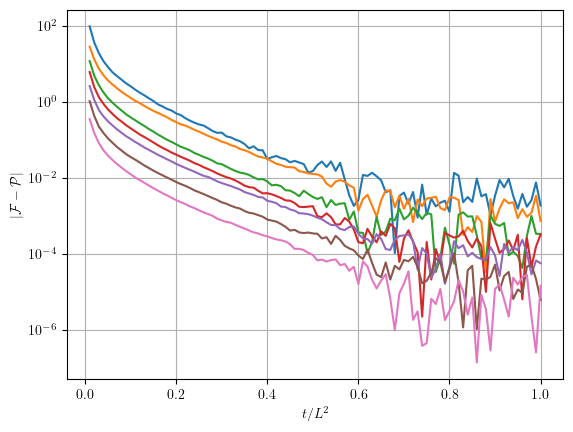

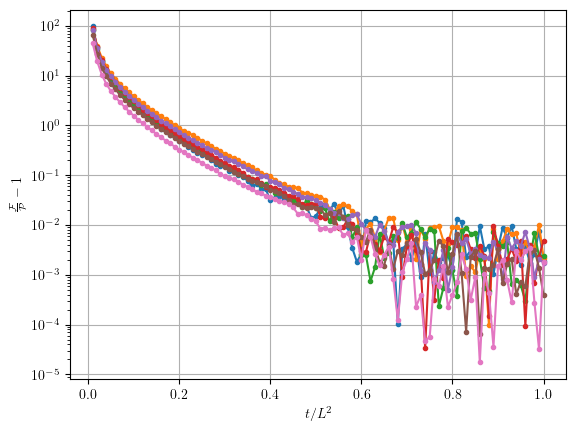

In [11]:
for tp, p in zip(true_purities, purities.mean(axis=1)):
    p = p[:100]
    plot_def = pyplot.plot(numpy.arange(1, len(p)+1) / L**2, p)
    pyplot.plot([1/L**2,(len(p)+1)/L**2] , [tp,tp], '--', c='gray') # c=plot_def[0].get_color())
pyplot.yscale('log')
pyplot.ylabel('$\mathcal{F}$')
pyplot.grid()
pyplot.show()

for tp, p in zip(true_purities, purities.mean(axis=1)):
    p = p[:100]
    pyplot.plot(numpy.arange(1, len(p)+1) / L**2, abs(p - tp))
pyplot.yscale('log')
pyplot.ylabel('$|\mathcal{F} - \mathcal{P}|$')
pyplot.xlabel('$t/L^2$')
pyplot.grid()
pyplot.show()

for tp, p in zip(true_purities, purities.mean(axis=1)):
    p = p[:100]
    pyplot.plot(numpy.arange(1, len(p)+1) / L**2, abs((p - tp)/tp), '.-')
pyplot.yscale('log')
pyplot.ylabel(r'$\frac{\mathcal{F}}{\mathcal{P}} - 1$')
pyplot.xlabel('$t/L^2$')
pyplot.grid()
pyplot.show()

The relative error on the purity estimator appears to be independent of $\mathcal{P}$, and decreases as approximately $e^{\frac{t}{2L^2}}$.

# Varying system size and purity

We now consider a similar experiment where we vary both the system size and the purity, maintaining the half-filling number sector.
The perplexingly named `run_for(L,M)` function prepares each $\rho_{2^k}$ for all allowed $k$ (except the totally mixed state), and repeatedly runs the purity estimator experiment for each. The resulting curves converge to $\mathcal{P}$ as before,

In [12]:
def run_for(L=10,M=5,layers=1000,experiments=16,trials=16,max_mixture=None):
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, M)
    hilbert_d = len(states)
    
    true_purities = []
    purities = []
    
    # for num_mixed in [hilbert_d // i for i in 2**numpy.arange(1, 1+int(numpy.floor(numpy.log2(hilbert_d))))][::-1]:
    for num_mixed in 2**numpy.arange(0, 1+int(numpy.floor(numpy.log2(hilbert_d)))):
        if max_mixture is not None:
            if max_mixture < num_mixed:
                break
        print(f"L={L} and M={M}: Mixing {num_mixed} of {hilbert_d}")
        purities.append(make_mixed_experiments(n_layers=layers, trials=trials, num_mixed=num_mixed, L=L, M=M, num_experiments_per_trial=experiments))
        true_purities.append(1/num_mixed)
    return numpy.array(purities), numpy.array(true_purities)

Consider $M=\frac{L}{2}$ for $L \in \{4, 6, 8, 10\}$

In [56]:
filename = os.path.join(basedir, "mixtures_2.npz")

if os.path.exists(filename):
    arr = numpy.load(filename, allow_pickle=True)
    all_purities_half = arr["all_purities_half"]
    all_true_purities_half = arr["all_true_purities_half"]
    Ls_half = arr["Ls_half"]
else:
    all_purities_half = {}
    all_true_purities_half = {}
    Ls_half = numpy.arange(4,12,2)
    
    for L in Ls_half:
        M = L//2
        purities, true_purities = run_for(L=L,M=M,experiments=32,trials=32, max_mixture=128)
        all_purities_half[L] = purities
        all_true_purities_half[L] = true_purities
    numpy.savez(filename, all_purities_half=all_purities_half, all_true_purities_half=all_true_purities_half, Ls_half=Ls_half)

L=4 and M=2: Mixing 1 of 6
L=4 and M=2: Mixing 2 of 6
L=4 and M=2: Mixing 4 of 6
L=6 and M=3: Mixing 1 of 20
L=6 and M=3: Mixing 2 of 20
L=6 and M=3: Mixing 4 of 20
L=6 and M=3: Mixing 8 of 20
L=6 and M=3: Mixing 16 of 20
L=8 and M=4: Mixing 1 of 70
L=8 and M=4: Mixing 2 of 70
L=8 and M=4: Mixing 4 of 70
L=8 and M=4: Mixing 8 of 70
L=8 and M=4: Mixing 16 of 70
L=8 and M=4: Mixing 32 of 70
L=8 and M=4: Mixing 64 of 70
L=10 and M=5: Mixing 1 of 252
L=10 and M=5: Mixing 2 of 252
L=10 and M=5: Mixing 4 of 252
L=10 and M=5: Mixing 8 of 252
L=10 and M=5: Mixing 16 of 252
L=10 and M=5: Mixing 32 of 252
L=10 and M=5: Mixing 64 of 252
L=10 and M=5: Mixing 128 of 252


Since many of these initial states have the same purity, we expect them to converge to the same values. We use color to indicate system size.

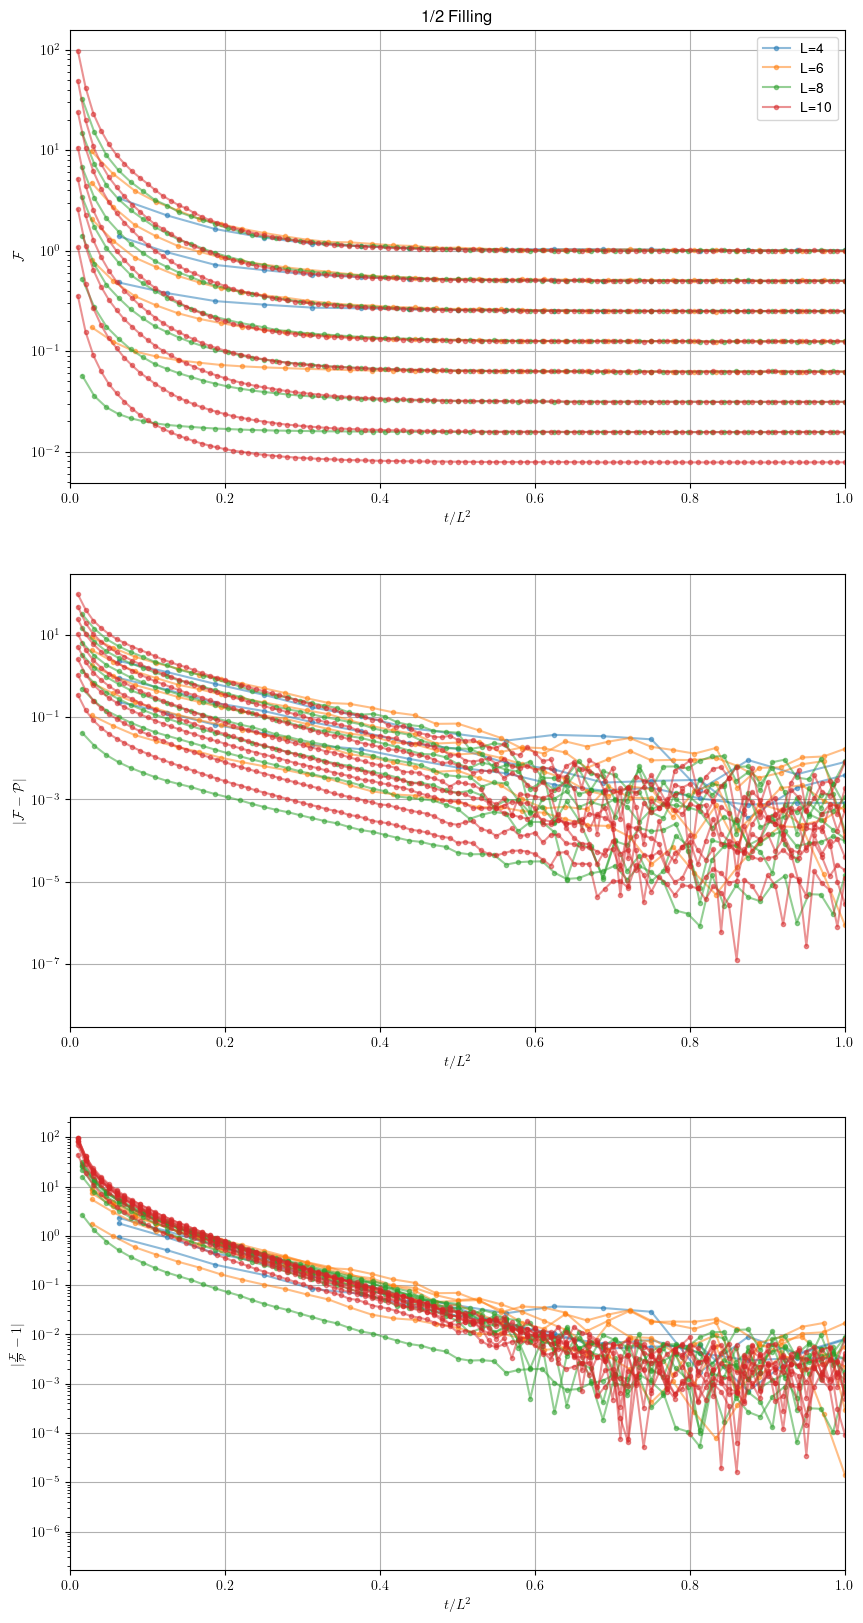

In [57]:
# fig, axs = pyplot.subplots(4, figsize=(10, 20))
fig, axs = pyplot.subplots(3, figsize=(10, 20))

# for L, purities, true_purities in zip(Ls_half, all_purities_half, all_true_purities_half):
for L in Ls_half:
    purities = all_purities_half[L]
    true_purities = all_true_purities_half[L]
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, L//2)
    hilbert_d = len(states)

    color = None
    label = f"L={L}"
    for mixed_p, tp in zip(purities, true_purities):
        p = mixed_p.mean(axis=0)
        plot = axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p, '.-', c=color, alpha=0.5, label=label)
        label = None
        color = plot[0].get_color()
        axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp), '.-', c=color, alpha=0.5)
        axs[2].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/(tp), '.-', c=color, alpha=0.5)
        # axs[3].plot(numpy.arange(1, len(p)+1), abs(p - tp)/(tp * hilbert_d), '.-', c=color, alpha=0.5)

axs[0].legend()

# axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim((0,1.0))
axs[0].grid()
# axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim((0,1.0))
axs[1].grid()
# axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim((0,1.0))
axs[2].grid()
# # axs[3].set_xscale('log')
# axs[3].set_yscale('log')
# axs[3].set_xlim((0,100))
# axs[3].grid()

axs[0].set_ylabel(r'$\mathcal{F}$')
axs[0].set_xlabel(r'$t/L^2$')
axs[1].set_ylabel(r'$|\mathcal{F} - \mathcal{P}|$')
axs[1].set_xlabel(r'$t/L^2$')
axs[2].set_ylabel(r'$|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')
axs[2].set_xlabel(r'$t/L^2$')
# axs[3].set_ylabel(r'$\frac{1}{D_n}|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')
# axs[3].set_xlabel(r'$t$')

axs[0].set_title("1/2 Filling")
pyplot.show()

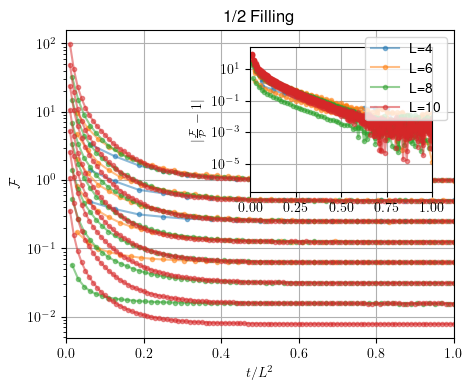

In [58]:
fig, ax = pyplot.subplots(figsize=[5, 4])
axins = ax.inset_axes([0.475, 0.475, 0.47, 0.47])

# for L, purities, true_purities in zip(Ls_half, all_purities_half, all_true_purities_half):
for L in Ls_half:
    purities = all_purities_half[L]
    true_purities = all_true_purities_half[L]
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, L//2)
    hilbert_d = len(states)

    color = None
    label = f"L={L}"
    for mixed_p, tp in zip(purities, true_purities):
        p = mixed_p.mean(axis=0)
        plot = ax.plot(numpy.arange(1, len(p)+1)/L**2, p, '.-', c=color, alpha=0.5, label=label)
        label = None
        color = plot[0].get_color()
        axins.plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/(tp), '.-', c=color, alpha=0.5)
        # axs[3].plot(numpy.arange(1, len(p)+1), abs(p - tp)/(tp * hilbert_d), '.-', c=color, alpha=0.5)

ax.legend()

ax.set_yscale('log')
ax.set_xlim((0,1.0))
ax.grid()
axins.set_yscale('log')
axins.set_xlim((0,1.0))
axins.grid()

ax.set_ylabel(r'$\mathcal{F}$')
ax.set_xlabel(r'$t/L^2$')
axins.set_ylabel(r'$|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')

ax.set_title("1/2 Filling")
pyplot.show()

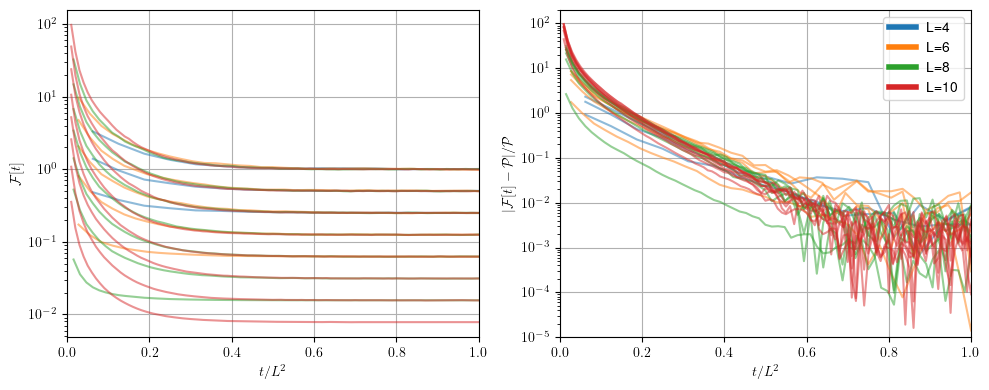

In [81]:
fig, axs = pyplot.subplots(1, 2, figsize=(10,4))

# for L, purities, true_purities in zip(Ls_half, all_purities_half, all_true_purities_half):
custom_lines = []
for L in Ls_half:
    purities = all_purities_half[L]
    true_purities = all_true_purities_half[L]
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, L//2)
    hilbert_d = len(states)

    color = None
    label = f"L={L}"
    for mixed_p, tp in zip(purities, true_purities):
        p = mixed_p.mean(axis=0)
        plot = axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p, '-', c=color, alpha=0.5, label=label)
        label = None
        color = plot[0].get_color()
        plot = axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/(tp), '-', c=color, alpha=0.5, label=label)
    custom_lines.append(Line2D([0], [0], color=plot[0].get_color(), lw=4))

axs[0].set_yscale('log')
axs[0].set_xlim((0,1.0))
axs[0].grid()
axs[1].set_yscale('log')
axs[1].set_xlim((0,1.0))
axs[1].grid()

axs[0].set_ylabel(r'$\mathcal{F}[t]$')
axs[0].set_xlabel(r'$t/L^2$')
axs[1].set_ylabel(r'$|\mathcal{F}[t] - \mathcal{P}|/\mathcal{P}$')
axs[1].set_xlabel(r'$t/L^2$')
axs[1].set_ylim((1e-5,2e2))


axs[1].legend(custom_lines, [f"L={L}" for L in Ls_half])

fig.tight_layout()

pyplot.savefig(os.path.join(basedir, "fig_mixed.pdf"))
pyplot.show()

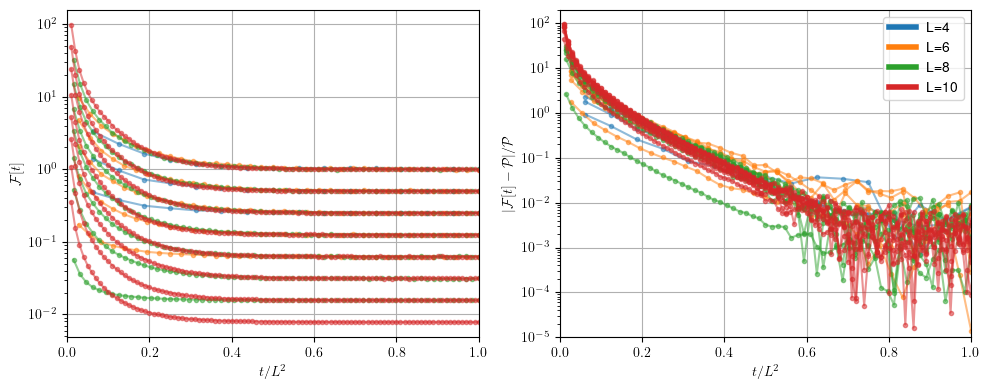

In [80]:
fig, axs = pyplot.subplots(1, 2, figsize=(10,4))

# for L, purities, true_purities in zip(Ls_half, all_purities_half, all_true_purities_half):
custom_lines = []
for L in Ls_half:
    purities = all_purities_half[L]
    true_purities = all_true_purities_half[L]
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, L//2)
    hilbert_d = len(states)

    color = None
    label = f"L={L}"
    for mixed_p, tp in zip(purities, true_purities):
        p = mixed_p.mean(axis=0)
        plot = axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p, '.-', c=color, alpha=0.5, label=label)
        label = None
        color = plot[0].get_color()
        plot = axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/(tp), '.-', c=color, alpha=0.5, label=label)
    custom_lines.append(Line2D([0], [0], color=plot[0].get_color(), lw=4))

axs[0].set_yscale('log')
axs[0].set_xlim((0,1.0))
axs[0].grid()
axs[1].set_yscale('log')
axs[1].set_xlim((0,1.0))
axs[1].grid()

axs[0].set_ylabel(r'$\mathcal{F}[t]$')
axs[0].set_xlabel(r'$t/L^2$')
axs[1].set_ylabel(r'$|\mathcal{F}[t] - \mathcal{P}|/\mathcal{P}$')
axs[1].set_xlabel(r'$t/L^2$')
axs[1].set_ylim((1e-5,2e2))


axs[1].legend(custom_lines, [f"L={L}" for L in Ls_half])

fig.tight_layout()

pyplot.savefig(os.path.join(basedir, "fig_mixed_2.pdf"))

pyplot.show()

Note that the relative error lines collapse when time is rescaled by $\frac{1}{L^2}$ -- independent of the true purity of the state, the estimator reaches the relative error $|\frac{\mathcal{F}}{\mathcal{P}} - 1| \simeq \varepsilon$ in a time of order $O(\frac{L^2}{\varepsilon})$

Lets repeat the experiment at $L/3$ filling

In [9]:
all_purities_third = []
all_true_purities_third = []
Ls_third = numpy.arange(3,15,3)
for L in Ls_third:
    M = L//3
    purities, true_purities = run_for(L=L,M=M,experiments=16,trials=16, max_mixture=128)
    all_purities_third.append(purities)
    all_true_purities_third.append(true_purities)

L=3 and M=1: Mixing 1 of 3
L=3 and M=1: Mixing 2 of 3
L=6 and M=2: Mixing 1 of 15
L=6 and M=2: Mixing 2 of 15
L=6 and M=2: Mixing 4 of 15
L=6 and M=2: Mixing 8 of 15
L=9 and M=3: Mixing 1 of 84
L=9 and M=3: Mixing 2 of 84
L=9 and M=3: Mixing 4 of 84
L=9 and M=3: Mixing 8 of 84
L=9 and M=3: Mixing 16 of 84
L=9 and M=3: Mixing 32 of 84
L=9 and M=3: Mixing 64 of 84
L=12 and M=4: Mixing 1 of 495
L=12 and M=4: Mixing 2 of 495
L=12 and M=4: Mixing 4 of 495
L=12 and M=4: Mixing 8 of 495
L=12 and M=4: Mixing 16 of 495
L=12 and M=4: Mixing 32 of 495
L=12 and M=4: Mixing 64 of 495
L=12 and M=4: Mixing 128 of 495


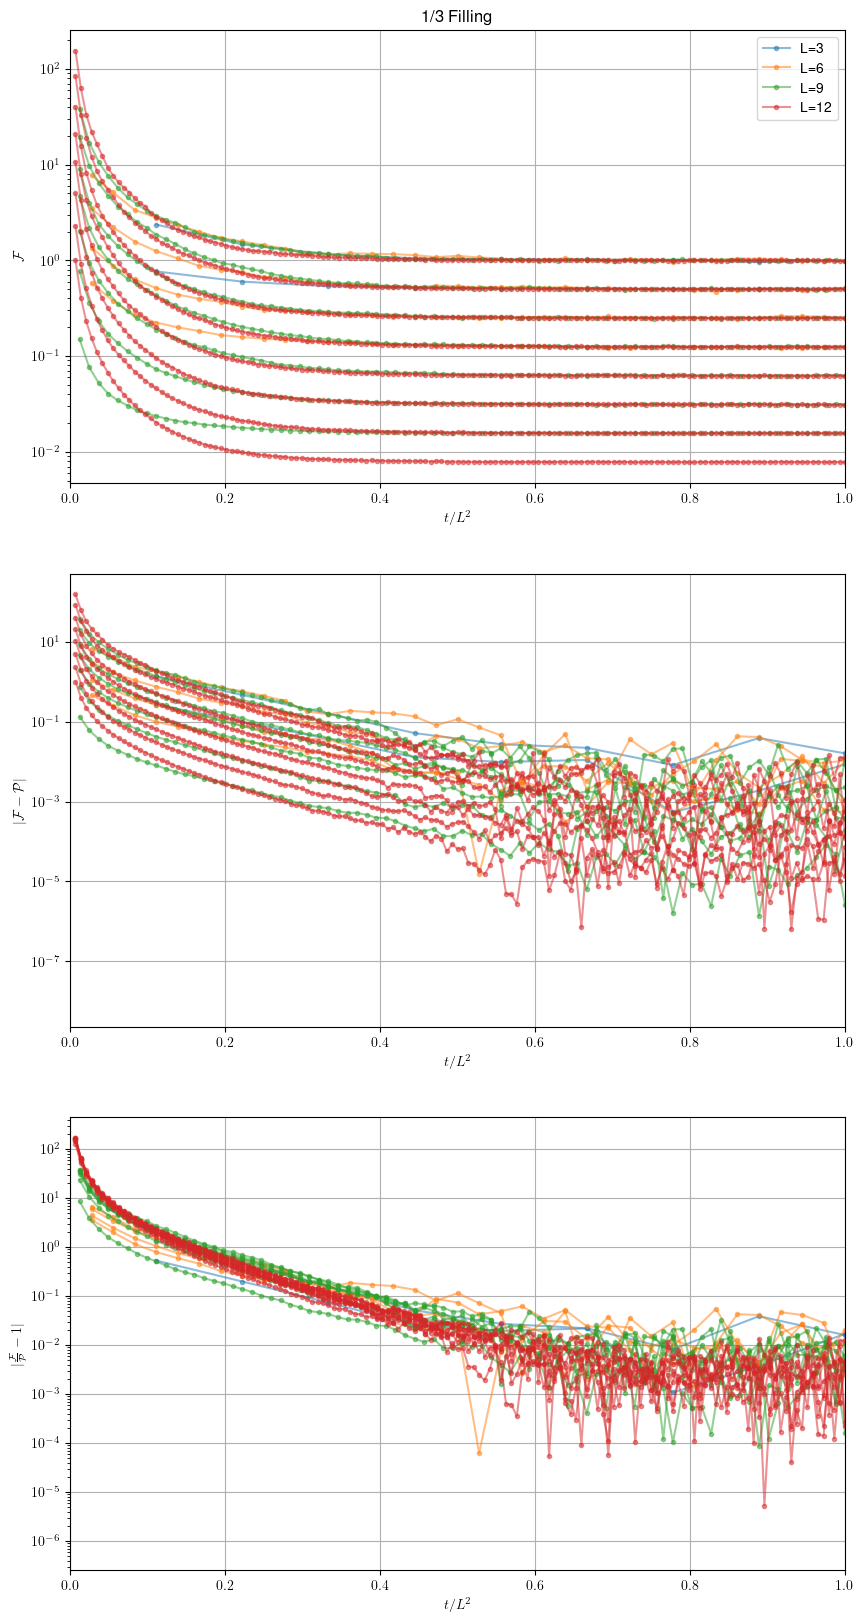

In [30]:
# fig, axs = pyplot.subplots(4, figsize=(10, 20))
fig, axs = pyplot.subplots(3, figsize=(10, 20))

for L, purities, true_purities in zip(Ls_third, all_purities_third, all_true_purities_third):
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, L//3)
    hilbert_d = len(states)

    color = None
    label = f"L={L}"
    for mixed_p, tp in zip(purities, true_purities):
        p = mixed_p.mean(axis=0)
        plot = axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p, '.-', c=color, alpha=0.5, label=label)
        color = plot[0].get_color()
        label = None
        axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp), '.-', c=color, alpha=0.5)
        axs[2].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/(tp), '.-', c=color, alpha=0.5)
        # axs[3].plot(numpy.arange(1, len(p)+1), abs(p - tp)/(tp * hilbert_d), '.-', c=color, alpha=0.5)

axs[0].legend()

# axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim((0,1.0))
axs[0].grid()
# axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim((0,1.0))
axs[1].grid()
# axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim((0,1.0))
axs[2].grid()
# # axs[3].set_xscale('log')
# axs[3].set_yscale('log')
# axs[3].set_xlim((0,100))
# axs[3].grid()

axs[0].set_ylabel(r'$\mathcal{F}$')
axs[0].set_xlabel(r'$t/L^2$')
axs[1].set_ylabel(r'$|\mathcal{F} - \mathcal{P}|$')
axs[1].set_xlabel(r'$t/L^2$')
axs[2].set_ylabel(r'$|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')
axs[2].set_xlabel(r'$t/L^2$')
# axs[3].set_ylabel(r'$\frac{1}{D_n}|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')
# axs[3].set_xlabel(r'$t$')

axs[0].set_title("1/3 Filling")
pyplot.show()

# Momentum modes


In [30]:
def make_mixed_momenta(n_layers=100, trials=16, num_mixed=16, num_experiments_per_trial=32, L=10, M=5):
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, M)

    unit = numpy.array([1.0 + 0.0j])

    purities = []
    for _ in range(trials):
        choices = numpy.random.choice(numpy.arange(len(states)), replace=False, size=(num_mixed))
        chosen_states = states[choices]
        pure_states = [py_entropy.MultidefectPureState(chosen_states[[i],:], unit) for i in range(num_mixed)]
        state = py_entropy.MultiDefectState.new_mixed_from_states(states=[(1.0/num_mixed, state) for state in pure_states], 
                                                                  n_sites=L,
                                                                  num_experiments=num_experiments_per_trial,
                                                                  skip_float_checks=True)
        purity = state.apply_alternative_layers_and_save_mean_purity(n_layers)
        purities.append(purity)
    return numpy.array(purities)


def run_momentum_mode(L=10,M=5,layers=1000,num_experiments=16,max_mixture=None,q=None, throw_out_below=1e-6):
    if q is None:
        q = 2*numpy.pi / L
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, M)
    weights = []
    for state in states:
        w = abs(sum(numpy.exp(1.0j * q * x) for x in state))
        if w < throw_out_below:
            w = 0.0
        weights.append(w)
    net_weight = sum(weights)
    weights = numpy.array([w / net_weight for w in weights])
    true_purity = (weights**2).sum()

    state_tuples = []
    for (w, state) in zip(weights, states):
        if w > 1e-12:
            state = py_entropy.MultidefectPureState(numpy.expand_dims(state, axis=0), numpy.array([1.0 + 0.0j]))
            state_tuples.append((w, state))
    state = py_entropy.MultiDefectState.new_mixed_from_states(states=state_tuples, 
                                                              n_sites=L,
                                                              num_experiments=num_experiments,
                                                              skip_float_checks=True)
    
    return state.apply_alternative_layers_and_save_mean_purity(layers), true_purity

In [36]:
L = 10
M = 5
purity, true_purity = run_momentum_mode(L,M, num_experiments=1024)

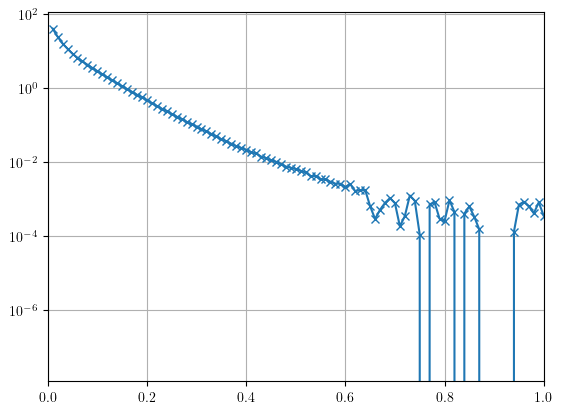

In [37]:
pyplot.plot(numpy.arange(1,1+len(purity))/L**2, purity / true_purity - 1, 'x-')
pyplot.yscale('log')
pyplot.xlim((0,1))
pyplot.grid()

In [43]:
results = []
Ls = [4,6,8,10,12]
for L in Ls:
    M = L//2
    purity, true_purity = run_momentum_mode(L,M, num_experiments=64)
    results.append((purity, true_purity))

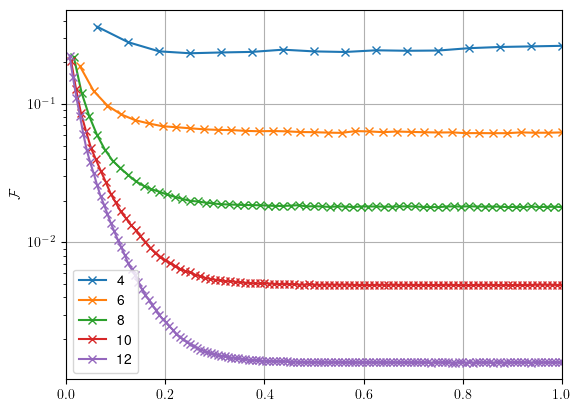

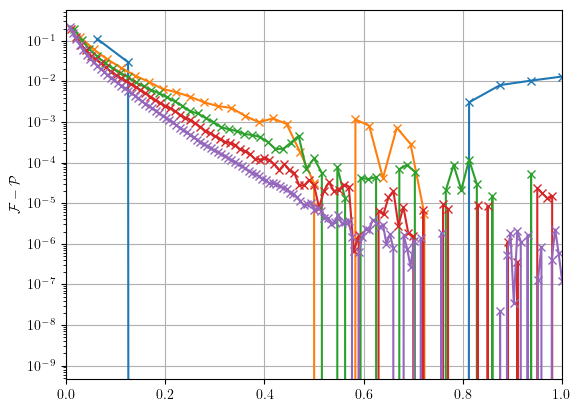

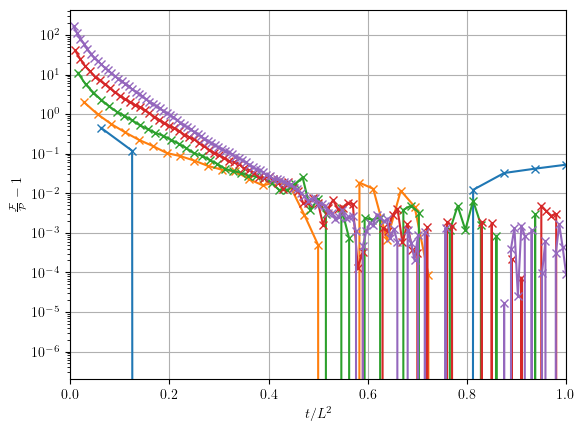

In [46]:
for L, (purity, true_purity) in zip(Ls, results):
    pyplot.plot(numpy.arange(1,1+len(purity))/L**2, purity, 'x-', label=str(L))
pyplot.yscale('log')
pyplot.xlim((0,1))
pyplot.grid()
pyplot.ylabel(r'$\mathcal{F}$')
pyplot.legend()
pyplot.show()

for L, (purity, true_purity) in zip(Ls, results):
    pyplot.plot(numpy.arange(1,1+len(purity))/L**2, purity - true_purity, 'x-')
pyplot.yscale('log')
pyplot.xlim((0,1))
pyplot.grid()
pyplot.ylabel(r'$\mathcal{F} - \mathcal{P}$')
pyplot.show()

for L, (purity, true_purity) in zip(Ls, results):
    pyplot.plot(numpy.arange(1,1+len(purity))/L**2, purity / true_purity - 1, 'x-')
pyplot.yscale('log')
pyplot.xlim((0,1))
pyplot.grid()
pyplot.ylabel(r'$\frac{\mathcal{F}}{\mathcal{P}} - 1$')
pyplot.xlabel(r'$t/L^2$')
pyplot.show()

# Dimer compare

Lets look at some states in the $M=1$ particle sector with structure, first the classic dimer versus mixed setup:
$$\rho_{dimer} = \frac{1}{2}\left(\ket{0} + \ket{L}\right)\left(\bra{0} + \bra{L}\right)$$

$$\rho_{mixed} = \frac{1}{2}\left(\ketbra{0}{0} + \ketbra{L}{L}\right)$$

In [31]:
ne = 128
n_layers = 10000

all_purities = []

ls = 10*numpy.arange(1,11)
for l in tqdm(ls):
    state = numpy.array([1/numpy.sqrt(2)] + [0]*(l-2) + [1/numpy.sqrt(2)], dtype=numpy.complex128)
    part_on_bound = py_entropy.SingleDefectState(state, num_experiments=ne)
    purities = part_on_bound.apply_alternative_layers_and_save_mean_purity(n_layers)
    all_purities.append(purities)
pure_both_purities = numpy.array(all_purities)
    
print(f"Purity shape: {pure_both_purities.shape}")

all_purities = []

ls = 10*numpy.arange(1,11)


for l in tqdm(ls):
    all_states = []

    x = [0]*l
    x[0] = 1
    all_states.append(numpy.asarray(x, dtype=numpy.complex128))

    x = [0]*l
    x[-1] = 1
    all_states.append(numpy.asarray(x, dtype=numpy.complex128))

    part_on_bound = py_entropy.SingleDefectState.new_mixed([(0.5, s) for s in all_states], num_experiments=ne)
    purities = part_on_bound.apply_alternative_layers_and_save_mean_purity(n_layers)
    all_purities.append(purities)
mixed_purities = numpy.array(all_purities)

  0%|          | 0/10 [00:00<?, ?it/s]

Purity shape: (10, 10000)


  0%|          | 0/10 [00:00<?, ?it/s]

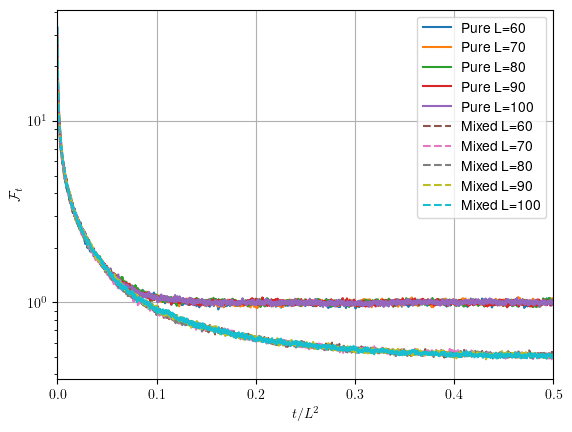

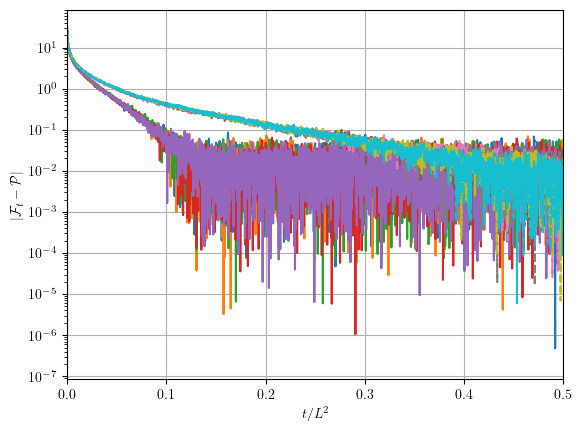

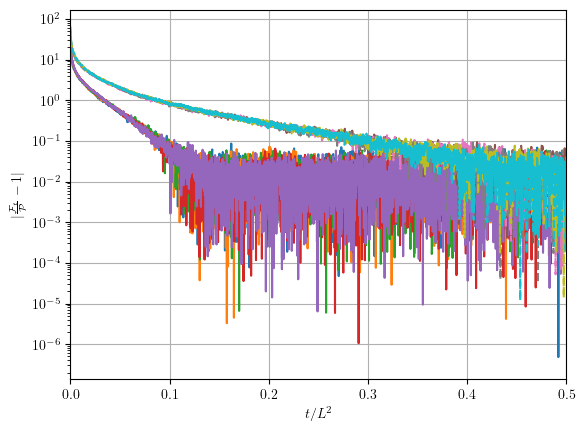

In [41]:
for l, purity in zip(ls[5:], pure_both_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), purity, '-', label=f"Pure L={l}")
for l, purity in zip(ls[5:], mixed_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), purity, '--', label=f"Mixed L={l}")
    
pyplot.xlabel('$t/L^2$')
pyplot.ylabel(r'$\mathcal{F}_t$')
pyplot.yscale('log')
pyplot.xlim((0.0,0.5))
# pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.show()

for l, purity in zip(ls[5:], pure_both_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), abs(purity - 1.0), '-', label=f"Pure L={l}")
for l, purity in zip(ls[5:], mixed_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), abs(purity - 0.5), '--', label=f"Mixed L={l}")
    
pyplot.xlabel('$t/L^2$')
pyplot.ylabel(r'$|\mathcal{F}_t - \mathcal{P}|$')
pyplot.yscale('log')
pyplot.xlim((0.0,0.5))
# pyplot.xscale('log')
# pyplot.legend()
pyplot.grid()
pyplot.show()

for l, purity in zip(ls[5:], pure_both_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), abs(purity - 1.0)/1.0, '-', label=f"Pure L={l}")
for l, purity in zip(ls[5:], mixed_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), abs(purity - 0.5)/0.5, '--', label=f"Mixed L={l}")
    
pyplot.xlabel('$t/L^2$')
pyplot.ylabel(r'$|\frac{\mathcal{F}_t}{\mathcal{P}} - 1|$')
pyplot.yscale('log')
pyplot.xlim((0.0,0.5))
# pyplot.xscale('log')
# pyplot.legend()
pyplot.grid()
pyplot.show()

This time the curves don't appear to sit directly on top of one another, there's a clear distinction between the pure and mixed states, notice the relative error for the mixed states stays higher much longer than that of the pure state.

# Chunks of Dimers

We restrict to a single particle sector, the particle can be found in one of `num_mixed` sites. We control the purity in this case by deciding how many of the sites are in superpositions versus mixtures.

For example, lets say we had a 1/6 chance of finding the particle on each of sites 1, 2, 3, 4, 5, 6. We would consider initial states:
$$\rho_1 = \left(\ket{1} + \ket{2} + \ket{3} + \ket{4} + \ket{5} + \ket{6}\right)\left(\bra{1} + \bra{2} + \bra{3} + \bra{4} + \bra{5} + \bra{6}\right)$$

$$\rho_2 = \frac{1}{2}\left(\ket{1} + \ket{2} + \ket{3}\right)\left(\bra{1} + \bra{2} + \bra{3}\right) + \frac{1}{2}\left(\ket{4} + \ket{5} + \ket{6}\right)\left(\bra{4} + \bra{5} + \bra{6}\right)$$


$$\rho_3 = \frac{1}{3}\left(\ket{1} + \ket{2}\right)\left(\bra{1} + \bra{2}\right) + \frac{1}{3}\left(\ket{3} + \ket{4}\right)\left(\bra{3} + \bra{4}\right) + \frac{1}{3}\left(\ket{5} + \ket{6}\right)\left(\bra{5} + \bra{6}\right)$$

and finally the fully mixed $\rho_6 = \frac{1}{3}\sum_b \ketbra{b}{b}$

In [45]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

list(chunks([0, 5, 10, 15, 20, 25], 2))

[[0, 5], [10, 15], [20, 25]]

In [47]:
def check_dimer_purities(L,num_mixed):
    purities = []
    true_purities = []
    
    states = numpy.arange(0,L, (L-1)//(num_mixed-1))
    
    # Go from all pure, to groups of 2, 4, etc
    
    dimer_states = []
    for dimer_size in 2**numpy.arange(0, 1+int(numpy.floor(numpy.log2(num_mixed)))):
        dimers_in_mixture = numpy.array(list(chunks(states, dimer_size)), dtype=numpy.uint64)
    
        dimers_in_mixture_states = []
        for dimer in dimers_in_mixture:
            if len(dimer.shape) == 1:
                dimer = numpy.expand_dims(dimer, axis=1)
        
            amplitudes = numpy.ones((dimer_size,),dtype=numpy.complex128)/numpy.sqrt(dimer_size)
            state = py_entropy.MultidefectPureState(dimer, amplitudes)
            dimers_in_mixture_states.append(state)
    
        mixed_state = [(1/len(dimers_in_mixture_states), state) for state in dimers_in_mixture_states] 
        state = py_entropy.MultiDefectState.new_mixed_from_states(states=mixed_state, 
                                                                  n_sites=L,
                                                                  num_experiments=32,
                                                                  skip_float_checks=False)
        purity = state.apply_alternative_layers_and_save_mean_purity(n_layers)
        purities.append(purity)
        true_purities.append(1/len(dimers_in_mixture_states))
    return numpy.array(purities), numpy.array(true_purities)

Start by considering $L=128$ with the particle in one of $2$ positions (0 or L-1), this is the same as the dimer setup above.

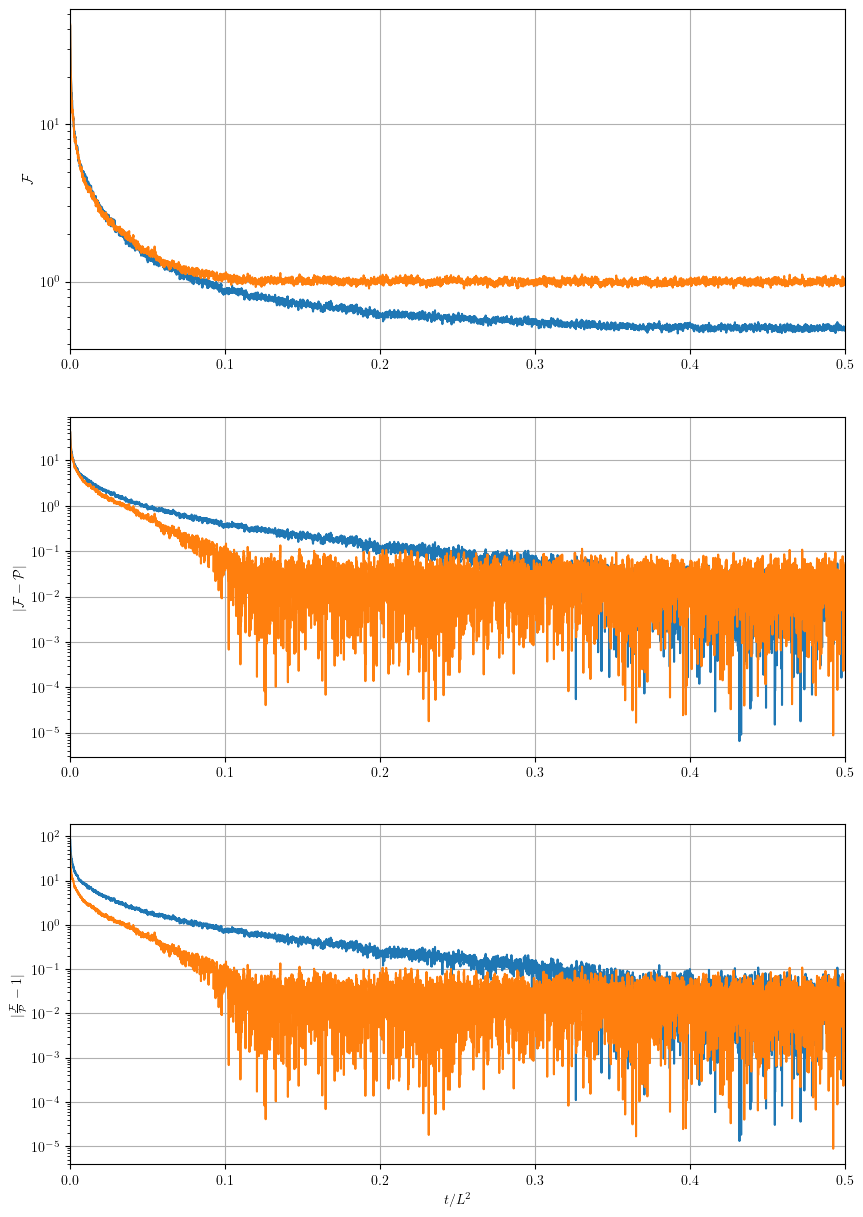

In [58]:
fig, axs = pyplot.subplots(3, figsize=(10,15))

L = 128
ps, tps = check_dimer_purities(128, 2)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp))
    axs[2].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/tp)
# axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim((0,0.5))
axs[0].set_ylabel(r'$\mathcal{F}$')
# axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim((0,0.5))
axs[1].set_ylabel(r'$|\mathcal{F} - \mathcal{P}|$')

axs[2].set_yscale('log')
axs[2].set_xlim((0,0.5))
axs[2].set_ylabel(r'$|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')

axs[2].set_xlabel(r'$t/L^2$')

axs[0].grid()
axs[1].grid()
axs[2].grid()
pyplot.show()

Now consider 4 equidistant points, the particle can be found at 0, L/3, 2L/3, or L-1

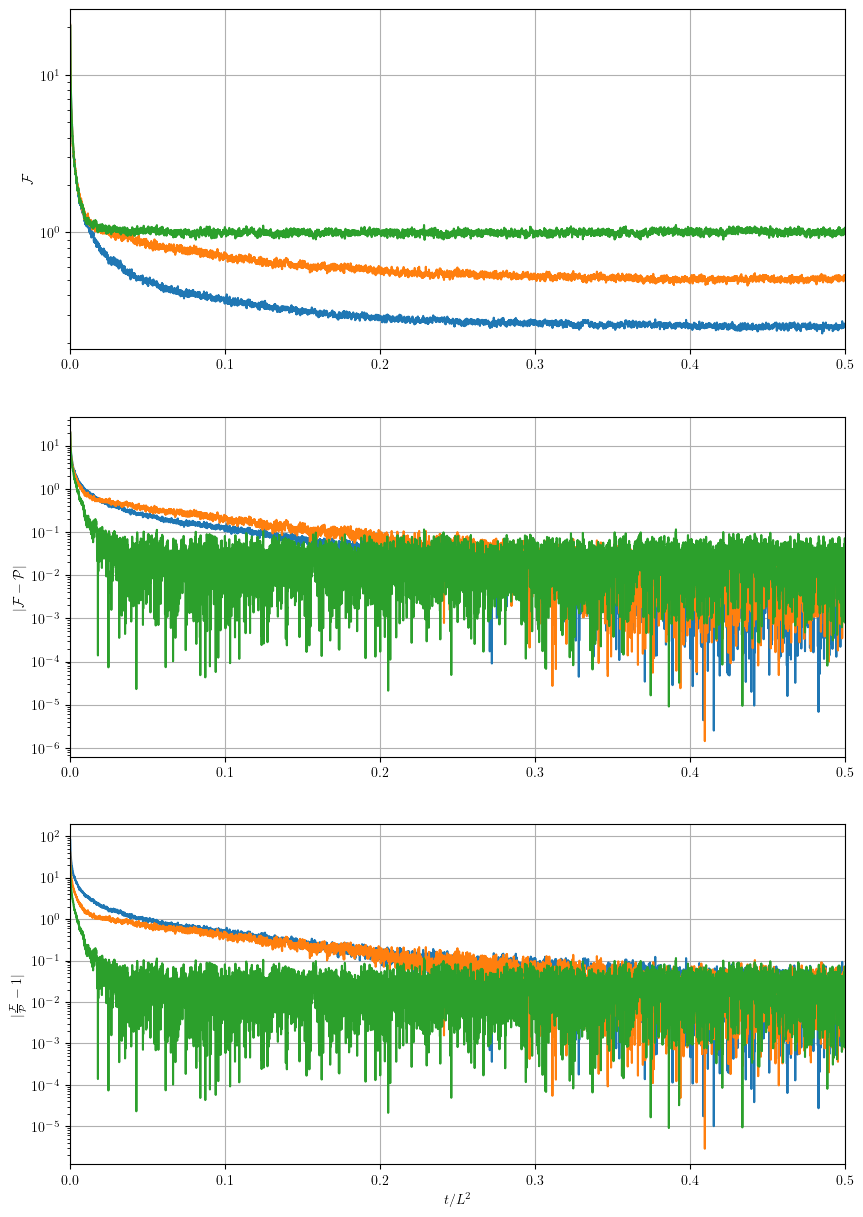

In [60]:
fig, axs = pyplot.subplots(3, figsize=(10,15))

L = 128
ps, tps = check_dimer_purities(128, 4)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp))
    axs[2].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/tp)
# axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim((0,0.5))
axs[0].set_ylabel(r'$\mathcal{F}$')
# axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim((0,0.5))
axs[1].set_ylabel(r'$|\mathcal{F} - \mathcal{P}|$')

axs[2].set_yscale('log')
axs[2].set_xlim((0,0.5))
axs[2].set_ylabel(r'$|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')

axs[2].set_xlabel(r'$t/L^2$')

axs[0].grid()
axs[1].grid()
axs[2].grid()
pyplot.show()

And now 8 equidistant points

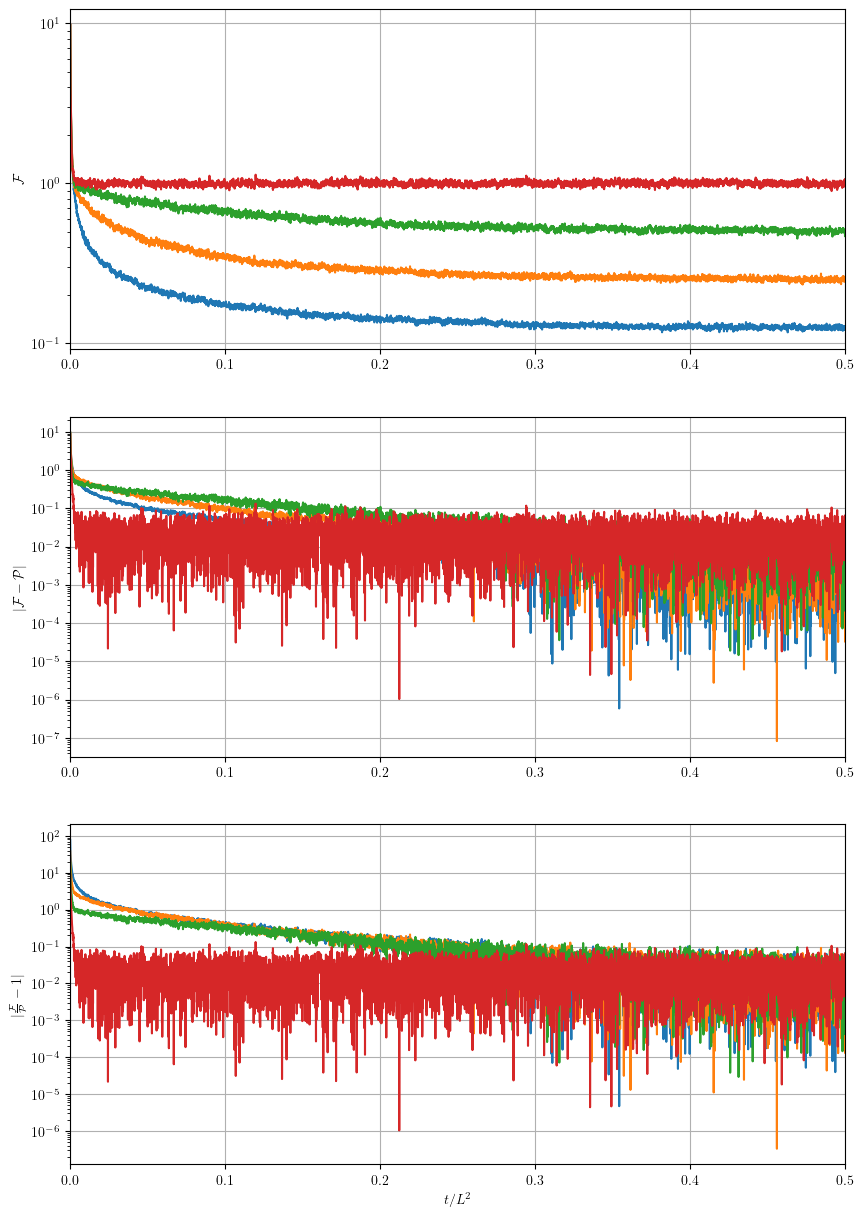

In [61]:
fig, axs = pyplot.subplots(3, figsize=(10,15))

L = 128
ps, tps = check_dimer_purities(128, 8)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp))
    axs[2].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/tp)
# axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim((0,0.5))
axs[0].set_ylabel(r'$\mathcal{F}$')
# axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim((0,0.5))
axs[1].set_ylabel(r'$|\mathcal{F} - \mathcal{P}|$')

axs[2].set_yscale('log')
axs[2].set_xlim((0,0.5))
axs[2].set_ylabel(r'$|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')

axs[2].set_xlabel(r'$t/L^2$')

axs[0].grid()
axs[1].grid()
axs[2].grid()
pyplot.show()

Now 64 points

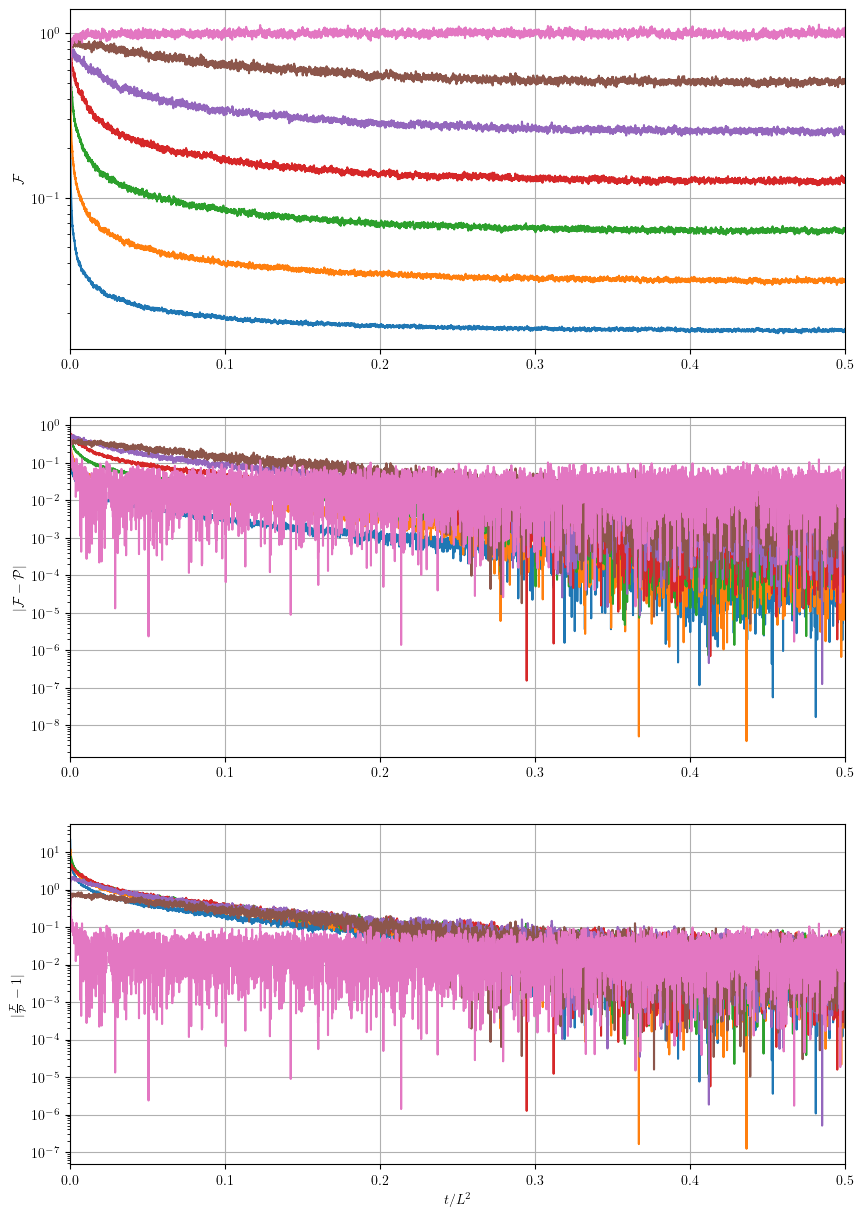

In [62]:
fig, axs = pyplot.subplots(3, figsize=(10,15))

ps, tps = check_dimer_purities(128, 64)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp))
    axs[2].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/tp)
# axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim((0,0.5))
axs[0].set_ylabel(r'$\mathcal{F}$')
# axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim((0,0.5))
axs[1].set_ylabel(r'$|\mathcal{F} - \mathcal{P}|$')

axs[2].set_yscale('log')
axs[2].set_xlim((0,0.5))
axs[2].set_ylabel(r'$|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')

axs[2].set_xlabel(r'$t/L^2$')

axs[0].grid()
axs[1].grid()
axs[2].grid()
pyplot.show()

This one is weird, replotting with log-log

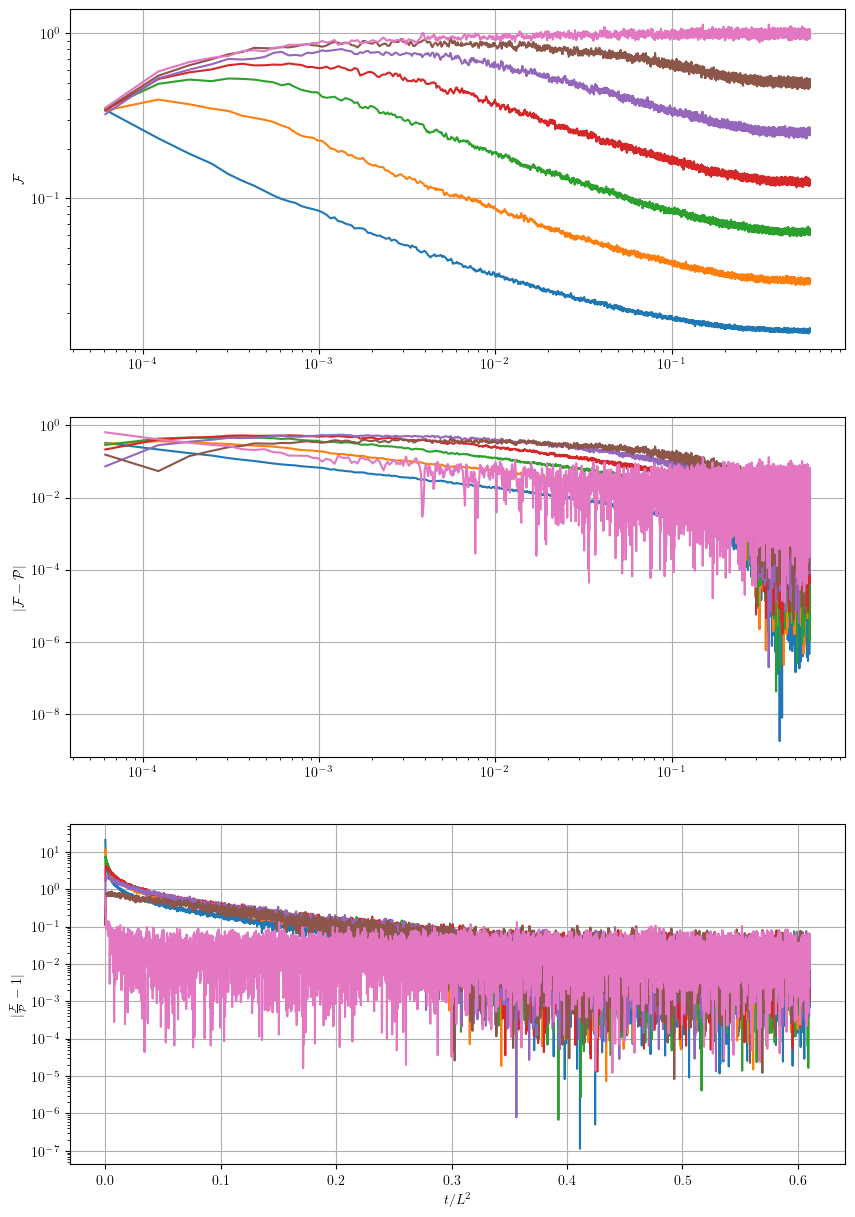

In [63]:
fig, axs = pyplot.subplots(3, figsize=(10,15))

ps, tps = check_dimer_purities(128, 64)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp))
    axs[2].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/tp)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
# axs[0].set_xlim((0,0.5))
axs[0].set_ylabel(r'$\mathcal{F}$')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
# axs[1].set_xlim((0,0.5))
axs[1].set_ylabel(r'$|\mathcal{F} - \mathcal{P}|$')

axs[2].set_yscale('log')
# axs[2].set_xlim((0,0.5))
axs[2].set_ylabel(r'$|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')

axs[2].set_xlabel(r'$t/L^2$')

axs[0].grid()
axs[1].grid()
axs[2].grid()
pyplot.show()